![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# URLs dos arquivos
filename_features = "https://raw.githubusercontent.com/Jefersonfranca/EBAC_Curso_Cientista_de_Dados/main/M%C3%B3dulo%2017%20%C3%81rvores%20II/dataset/features_info.txt"
filename_labels = "https://raw.githubusercontent.com/Jefersonfranca/EBAC_Curso_Cientista_de_Dados/main/M%C3%B3dulo%2017%20%C3%81rvores%20II/dataset/activity_labels.txt"
filename_subtrain = "https://raw.githubusercontent.com/Jefersonfranca/EBAC_Curso_Cientista_de_Dados/main/M%C3%B3dulo%2017%20%C3%81rvores%20II/dataset/subject_train.txt"
filename_xtrain = "https://raw.githubusercontent.com/Jefersonfranca/EBAC_Curso_Cientista_de_Dados/main/M%C3%B3dulo%2017%20%C3%81rvores%20II/dataset/X_train.txt"
filename_ytrain = "https://raw.githubusercontent.com/Jefersonfranca/EBAC_Curso_Cientista_de_Dados/main/M%C3%B3dulo%2017%20%C3%81rvores%20II/dataset/y_train.txt"
filename_subtest = "https://raw.githubusercontent.com/Jefersonfranca/EBAC_Curso_Cientista_de_Dados/main/M%C3%B3dulo%2017%20%C3%81rvores%20II/dataset/subject_test.txt"
filename_xtest = "https://raw.githubusercontent.com/Jefersonfranca/EBAC_Curso_Cientista_de_Dados/main/M%C3%B3dulo%2017%20%C3%81rvores%20II/dataset/X_test.txt"
filename_ytest = "https://raw.githubusercontent.com/Jefersonfranca/EBAC_Curso_Cientista_de_Dados/main/M%C3%B3dulo%2017%20%C3%81rvores%20II/dataset/y_test.txt"

# Carregar nomes de features
features = pd.read_csv(filename_features, header=None, sep="#")

# Definir os nomes das colunas
features.columns = ['nome_var']

# Carregar labels
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

# Carregar dados de treino
subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'])
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features['nome_var'].tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

# Carregar dados de teste
subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'])
X_test = pd.read_csv(filename_xtest, delim_whitespace=True, header=None, names=features['nome_var'].tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

In [2]:
# 1. Carregar dados de treino X_train
X_train.head()

# 2. Aplicar PCA sem padronização
pca = PCA()
X_train_pca = pca.fit_transform(X_train)

prcomp = PCA().fit(X_train)

In [3]:
def screeplot(princomp, ncomp = 0, varexplicada=0, criterio=1):
    
    if ncomp>0:
        ncomp_crit=ncomp
    elif varexplicada > 0:
        ncomp_crit = (princomp.explained_variance_ratio_.cumsum()<varexplicada).sum()+1 
        # Critério 1: autovalor padronizado > 1
    elif criterio == 1:
        ncomp_crit = (princomp.explained_variance_ratio_>1/princomp.n_components_).sum()
    else: ncomp_crit = None
    
    fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
    plt.subplots_adjust(hspace=0, wspace=.15)


    num_componentes = np.arange(princomp.n_components_) + 1
    ax[0,0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[0,0].set_title('Scree Plot - Variância total')
    ax[0,0].set_xlabel('Número de componentes')
    ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

    ax[1,0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[1,0].set_xlabel('Número de componentes')
    ax[1,0].set_ylabel('Variancia explicada (Acumulada)')


    ax[0,1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[0,1].set_title('Scree Plot - Variância percentual')
    ax[0,1].set_xlabel('Número de componentes')
    ax[0,1].set_ylabel('Variancia explicada (percentual)')

    ax[1,1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[1,1].set_xlabel('Número de componentes')
    ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')
    
    if ncomp_crit != None:
        # Linhas verticais de referência
        ax[0,0].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)
        ax[1,1].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)
        ax[1,0].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)
        ax[0,1].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)


        # linhas horizontais
        variancia               = princomp.explained_variance_[ncomp_crit-1]
        variancia_acumulada     = princomp.explained_variance_.cumsum()[ncomp_crit-1]
        pct_variancia           = princomp.explained_variance_ratio_[ncomp_crit-1]
        pct_variancia_acumulada = princomp.explained_variance_ratio_.cumsum()[ncomp_crit-1]
        
        ax[0,0].axhline(y = variancia              , color = 'r', linestyle = '-', linewidth=.5)
        ax[1,0].axhline(y = variancia_acumulada    , color = 'r', linestyle = '-', linewidth=.5)
        ax[0,1].axhline(y = pct_variancia          , color = 'r', linestyle = '-', linewidth=.5)
        ax[1,1].axhline(y = pct_variancia_acumulada, color = 'r', linestyle = '-', linewidth=.5)


    print(f'Número de componentes:............... {ncomp_crit}')
    print(f'Variância da ultima CP:.............. {variancia:.2f}' )
    print(f'Variância total explicada:........... {variancia_acumulada:.2f}' )
    print(f'Variância percentual da última CP:... {100*pct_variancia:.2f}%' )
    print(f'Variância percentual total explicada: {100*pct_variancia_acumulada:.2f}%' )
    plt.show()
    return ncomp_crit

Número de componentes:............... 10
Variância da ultima CP:.............. 0.11
Variância total explicada:........... 5.55
Variância percentual da última CP:... 1.80%
Variância percentual total explicada: 90.68%


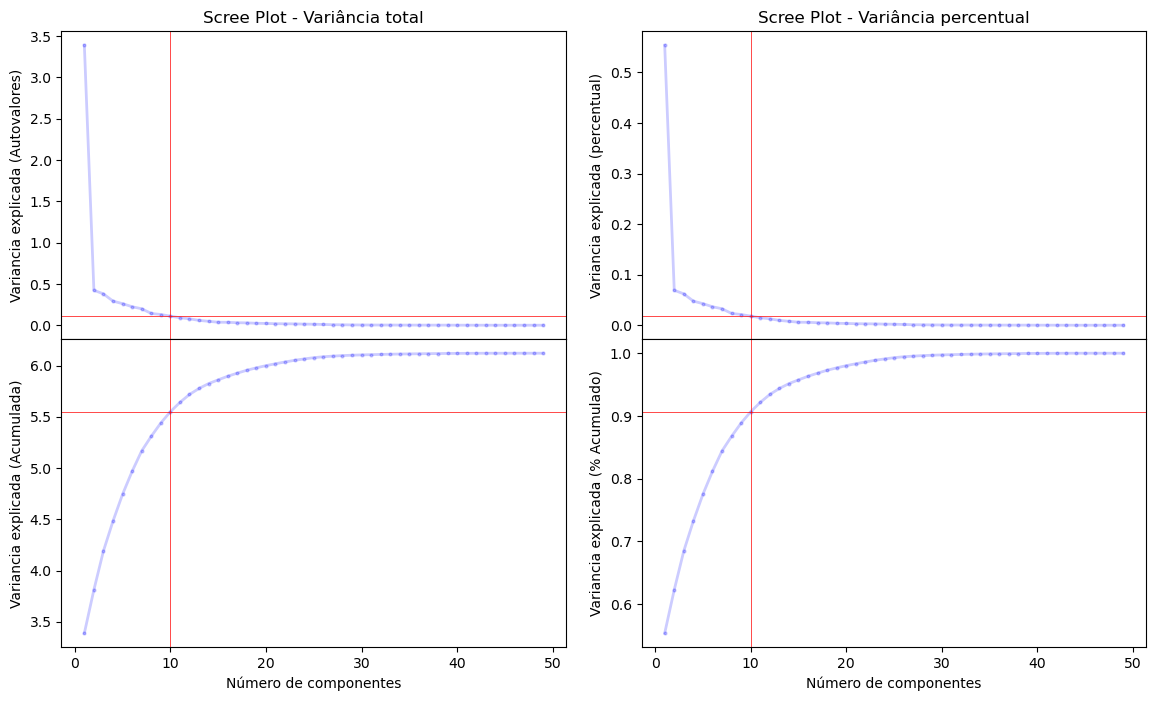

In [4]:
ncomp = screeplot(prcomp, varexplicada=.90)

In [5]:
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
X_train_pad.head()

CPU times: total: 15.6 ms
Wall time: 31.3 ms


,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Feature Selection,=================,"The features selected for this database come from the accelerometer and gyroscope 3-axial raw signals tAcc-XYZ and tGyro-XYZ. These time domain signals (prefix 't' to denote time) were captured at a constant rate of 50 Hz. Then they were filtered using a median filter and a 3rd order low pass Butterworth filter with a corner frequency of 20 Hz to remove noise. Similarly, the acceleration signal was then separated into body and gravity acceleration signals (tBodyAcc-XYZ and tGravityAcc-XYZ) using another low pass Butterworth filter with a corner frequency of 0.3 Hz.","Subsequently, the body linear acceleration and angular velocity were derived in time to obtain Jerk signals (tBodyAccJerk-XYZ and tBodyGyroJerk-XYZ). Also the magnitude of these three-dimensional signals were calculated using the Euclidean norm (tBodyAccMag, tGravityAccMag, tBodyAccJerkMag, tBodyGyroMag, tBodyGyroJerkMag).","Finally a Fast Fourier Transform (FFT) was applied to some of these signals producing fBodyAcc-XYZ, fBodyAccJerk-XYZ, fBodyGyro-XYZ, fBodyAccJerkMag, fBodyGyroMag, fBodyGyroJerkMag. (Note the 'f' to indicate frequency domain signals).",These signals were used to estimate variables of the feature vector for each pattern:,"'-XYZ' is used to denote 3-axial signals in the X, Y and Z directions.",tBodyAcc-XYZ,tGravityAcc-XYZ,tBodyAccJerk-XYZ,...,kurtosis(): kurtosis of the frequency domain signal,bandsEnergy(): Energy of a frequency interval within the 64 bins of the FFT of each window.,angle(): Angle between to vectors.,Additional vectors obtained by averaging the signals in a signal window sample. These are used on the angle() variable:,gravityMean,tBodyAccMean,tBodyAccJerkMean,tBodyGyroMean,tBodyGyroJerkMean,The complete list of variables of each feature vector is available in 'features.txt'
0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,0.963396,-0.140840,0.115375,-0.985250,-0.981708,-0.877625,-0.985001,-0.984416,-0.894677,0.892055,-0.161265,0.124660,0.977436,-0.123213,0.056483,-0.375426,0.899469,-0.970905,-0.975510,-0.984325,-0.988849,-0.917743,-1.0,-1.0,0.113806,-0.590425,0.591146,-0.591773,0.592469,-0.745449,0.720862,-0.712372,0.711300,-0.995112,0.995675,-0.995668,0.991653,0.570222,0.439027,0.986913,0.077996,0.005001,-0.067831,-0.993519,-0.988360,-0.993575,-0.994488,-0.986207,-0.992818,-0.985180,-0.991994,-0.993119,0.989835,0.991957,0.990519,-0.993522,-0.999935,-0.999820,-0.999878,-0.994364,-0.986025,-0.989234,-0.819949,-0.793046,-0.888853,1.000000,-0.220747,0.636831,0.387644,0.241401,-0.052253,0.264177,0.373439,0.341778,-0.569791,0.265399,-0.477875,-0.385300,0.033644,-0.126511,-0.006101,-0.031365,0.107725,-0.985310,-0.976623,-0.992205,-0.984586,-0.976353,-0.992362,-0.867044,-0.933786,-0.747566,0.847308,0.914895,0.830841,-0.967184,-0.999578,-0.999354,-0.999763,-0.983438,-0.978614,-0.992966,0.082632,0.202268,-0.168757,0.096323,-0.274985,0.498644,-0.220317,1.000000,-0.972971,0.316655,0.375726,0.723399,-0.771112,0.690213,-0.331831,0.709584,0.134873,0.301099,-0.099167,-0.055517,-0.061986,-0.992111,-0.992519,-0.992055,-0.992165,-0.994942,-0.992619,-0.990156,-0.986743,-0.9920

## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

In [5]:
%%time

# Árvore de decisão com base em dados padronizados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

clf_pca = DecisionTreeClassifier(ccp_alpha=0.001, random_state=42)
clf_pca.fit(X_train_pca, y_train)
y_pred_pca = clf_pca.predict(X_test_pca)
print(f'Acurácia na base de treino (padronizado): {accuracy_score(y_train, clf_pca.predict(X_train_pca))}')
print(f'Acurácia na base de teste (padronizado): {accuracy_score(y_test, y_pred_pca)}')

# Árvore de decisão sem padronizar
X_train_unscaled = X_train
X_test_unscaled = X_test

pca_unscaled = PCA(n_components=10)
X_train_pca_unscaled = pca_unscaled.fit_transform(X_train_unscaled)
X_test_pca_unscaled = pca_unscaled.transform(X_test_unscaled)

clf_unscaled = DecisionTreeClassifier(ccp_alpha=0.001, random_state=42)
clf_unscaled.fit(X_train_pca_unscaled, y_train)
y_pred_unscaled = clf_unscaled.predict(X_test_pca_unscaled)
print(f'Acurácia na base de treino (sem padronizar): {100*(accuracy_score(y_train, clf_unscaled.predict(X_train_pca_unscaled)))} %')
print(f'Acurácia na base de teste (sem padronizar): {100*(accuracy_score(y_test, y_pred_unscaled))} %')

Acurácia na base de treino (padronizado): 0.7819640914036997
Acurácia na base de teste (padronizado): 0.7037665422463523
Acurácia na base de treino (sem padronizar): 0.7869967355821545
Acurácia na base de teste (sem padronizar): 0.7251442144553784
CPU times: total: 1.02 s
Wall time: 247 ms
